In [1]:
import numpy as np
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

from tensorflow import keras

from os.path import join

mpl.style.use(["seaborn", "thesis"])

/home/jcartus/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Fetch Data

In [2]:
from SCFInitialGuess.utilities.dataset import extract_triu_batch, AbstractDataset
from sklearn.model_selection import train_test_split

data_path = "../dataset/TSmall_sto3g"
postfix = "TSmall_sto3g"
dim = 26
#data_path = "../butadien/data/"
#postfix = ""
#dim = 26


def split(x, y, ind):
    return x[:ind], y[:ind], x[ind:], y[ind:]

S = np.load(join(data_path, "S" + postfix + ".npy"))
P = np.load(join(data_path, "P" + postfix + ".npy"))
F = np.load(join(data_path, "F" + postfix + ".npy"))

index = np.load(join(data_path, "index" + postfix + ".npy"))



ind = int(0.8 * len(index))

# extract only test models
molecules = np.load(join(data_path, "molecules" + postfix + ".npy"))[ind:]

s_triu = extract_triu_batch(S, dim)
p_triu = extract_triu_batch(P, dim)

s_triu_norm, mu, std = AbstractDataset.normalize(s_triu)


s_train, p_train, s_test, p_test = split(s_triu_norm, p_triu, ind)

# Fetch Model 

In [3]:
filepath = "../models/TSmall_sto3gmodelTSmall_sto3g_250-150-50+triu.h5"
model = keras.models.load_model(filepath)

# Make Absolute Error Heatmap 

In [18]:
from SCFInitialGuess.utilities.dataset import reconstruct_from_triu

p_nn = model.predict(s_test)
error = np.mean(np.abs(p_nn - p_test), 0)

print("Mean abs. error: " + str(np.mean(error)))

error = reconstruct_from_triu(error, dim)                    

Mean abs. error: 0.0003380414403772439


In [67]:
import seaborn as sns

def matrix_error(error, xlabel=None, ylabel=None, ButadienMode=False, **kwargs):
    
    ax = sns.heatmap(
        error, 
        cmap="viridis", 
        #cmap="plasma",
        #cmap="YlGnBu", 
        #cmap="winter",
        #cmap="summer",
        #cmap="gist_earth",
        #cmap="ocean",
        **kwargs
    )
    #ax.set_xlabel(xlabel)
    #ax.set_ylabel(ylabel)
    
    cbar_min = np.min(error)
    cbar_max = np.max(error)
    cbar_step = (cbar_max - cbar_min) / 5
    
    cbar = ax.collections[0].colorbar
    cbar.ax.set_yticklabels(
        [
            '{:0.1E}'.format(x) for x in np.arange(cbar_min, cbar_max + cbar_step, cbar_step)
        ]
    )        

    if ButadienMode:
        C_labels = ["1s  ", "2s  ", "2px", "2py", "2pz"]
        H_labels = ["1s  "]
        labels = [
             "C" + str(ci) + ": " + orbital \
                for ci in range(1,5) for orbital in C_labels
        ] + [
            "H" + str(hi) + ": " + orbital \
                for hi in range(1,7) for orbital in H_labels
        ]


        plt.yticks(np.arange(26), labels, rotation=0) 
        plt.xticks(np.arange(26), labels, rotation='vertical') 


    plt.tight_layout()
        
    return ax


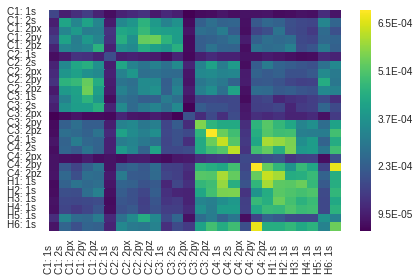

In [68]:
matrix_error(error, ButadienMode=True)

plt.savefig("/home/jcartus/Repos/MastersThesis/SMatrixDescriptor/figures/HeatMapNNAbsError.pdf")
plt.show()